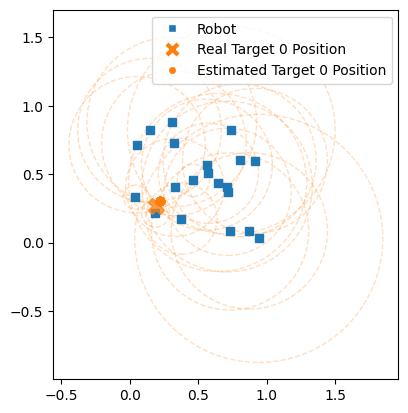

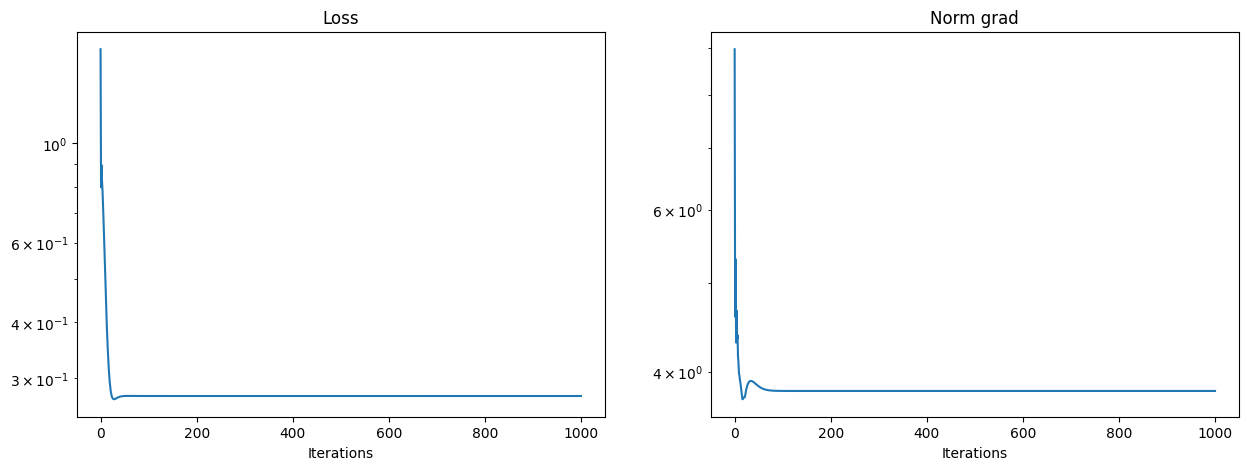

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from Function import LossFunctionTask1
from utils import gradient_tracking_algorithm, create_network_of_agents


def plot_scenario(
    robots_pos,
    targets_pos_real,
    est_targets_dists,
    est_targets_pos=None,
    num_targets=1,
):
    target_colors = ["tab:orange", "tab:purple", "tab:green"]

    for i in range(len(robots_pos)):
        plt.plot(robots_pos[i][0], robots_pos[i][1], "s", color="tab:blue")
    for i in range(len(targets_pos_real)):
        plt.plot(
            targets_pos_real[i][0],
            targets_pos_real[i][1],
            "X",
            color=target_colors[i],
            label=f"Target {i}",
            markersize=12,
            alpha=0.75,
        )
    for i in range(len(est_targets_dists)):
        for j in range(len(est_targets_dists[i])):
            plt.gca().add_patch(
                plt.Circle(
                    robots_pos[i],
                    est_targets_dists[i, j],
                    color=target_colors[j],
                    fill=False,
                    alpha=0.25,
                    linestyle="--",
                )
            )

    if est_targets_pos is not None:
        for i in range(num_targets):
            est_pos = est_targets_pos[:, i * VARS_DIM : (i + 1) * VARS_DIM]
            for j in range(len(est_pos)):
                plt.plot(
                    est_pos[j, 0],
                    est_pos[j, 1],
                    "o",
                    color=target_colors[i],
                    alpha=0.75,
                )

    plt.axis("scaled")
    handles = [
        plt.Line2D(
            [0], [0], marker="s", color="w", label="Robot", markerfacecolor="tab:blue"
        )
    ]
    for i in range(num_targets):
        handles += [
            plt.Line2D(
                [0],
                [0],
                marker="X",
                color="w",
                label=f"Real Target {i} Position",
                markerfacecolor=target_colors[i],
                markersize=12,
            ),
        ]

    if est_targets_pos is not None:
        for i in range(num_targets):
            handles += [
                plt.Line2D(
                    [0],
                    [0],
                    marker="o",
                    color="w",
                    label=f"Estimated Target {i} Position",
                    markerfacecolor=target_colors[i],
                ),
            ]
    plt.legend(handles=handles, loc="upper right", fontsize=10)


################################
# CONSTANTS
################################

NUM_ROBOTS = 20
NUM_TARGETS = 1
VARS_DIM = 2
NOISE_STD = 0.1

NUM_ITERATIONS = 1000
ALPHA = lambda k: (2e-2 / (k / 1000 + 1)) ** 0.5

SEED = 24

####################################
# PARAMETERS
####################################
rng = np.random.default_rng(SEED)

robots_pos = rng.random(size=(NUM_ROBOTS, VARS_DIM))
targets_pos_real = rng.random(size=(NUM_TARGETS, VARS_DIM))

est_targets_dists = np.zeros((NUM_ROBOTS, NUM_TARGETS))
for i in range(NUM_ROBOTS):
    for j in range(NUM_TARGETS):
        est_targets_dists[i, j] = np.linalg.norm(
            robots_pos[i] - targets_pos_real[j], 2
        ) + rng.normal(scale=NOISE_STD)


loss_fns = [
    LossFunctionTask1(robots_pos[i], est_targets_dists[i], NUM_TARGETS, VARS_DIM)
    for i in range(NUM_ROBOTS)
]

# Initial guess
z0 = rng.random(size=(NUM_ROBOTS, NUM_TARGETS * VARS_DIM))

# plot_scenario(robots_pos, targets_pos_real, est_targets_dists, num_targets=NUM_TARGETS)
# plt.show()

_, A = create_network_of_agents(
    NUM_ROBOTS,
    connected=True,
    self_loops=True,
    seed=SEED,
    graph_algorithm="erdos_renyi",
    erdos_renyi_p=0.3,
)

z_history = gradient_tracking_algorithm(
    fn_list=loss_fns,
    z0=z0.copy(),
    A=A,
    num_iters=NUM_ITERATIONS,
    alpha=ALPHA,
)

plot_scenario(
    robots_pos,
    targets_pos_real,
    est_targets_dists,
    z_history[-1],
    num_targets=NUM_TARGETS,
)
plt.show()


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.xlabel("Iterations")
plt.yscale("log")
plt.plot(
    range(len(z_history)),
    [sum(loss_fns[i](z[i].flatten()) for i in range(NUM_ROBOTS)) for z in z_history],
)

plt.subplot(1, 2, 2)
plt.title("Norm grad")
plt.xlabel("Iterations")
plt.yscale("log")
plt.plot(
    range(len(z_history)),
    [
        sum(np.linalg.norm(loss_fns[i].grad(z[i].flatten())) for i in range(NUM_ROBOTS))
        for z in z_history
    ],
)

plt.show()

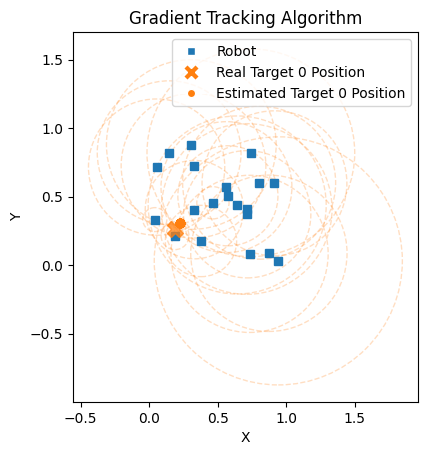

In [14]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from IPython.display import display
# Create an animation, by showing the scenario at each iteration
def animate_scenario(z_history, skip=2):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title("Gradient Tracking Algorithm")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    frames = range(0, 200, skip)

    def update(frame_idx):
        ax.clear()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title("Gradient Tracking Algorithm")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        plot_scenario(robots_pos, 
                      targets_pos_real,
                      est_targets_dists,
                      z_history[frames[frame_idx]],
                      num_targets=NUM_TARGETS)
        return (ax,)

    ani = FuncAnimation(fig, update, frames=len(frames), blit=False, interval=200)

    # Fix: Display the animation
    display(HTML(ani.to_jshtml()))

    # Save the animation as a video file
    ani.save("gradient_tracking_animation.mp4", fps=10, extra_args=["-vcodec", "libx264"])
    # plt.show()

animate_scenario(z_history, skip=4)